In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

In [2]:
## Evaluation metrics
def mean_absolute_percentage_error(y_true, y_pred, breakdown=False):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if breakdown:
        mape = (np.abs((y_true - y_pred) / y_true)) * 100
    else:
        mape = np.mean((np.abs((y_true - y_pred) / y_true)) * 100)
    return mape

def MdAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mdape = np.median(np.abs((y_true - y_pred) / y_true)) * 100
    return mdape

## Stationarity Test
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag=None,maxlag=12) # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
    return out

In [3]:
sale = pd.read_csv('train.csv')
features = pd.read_csv('features.csv')

sale['Date'] = pd.to_datetime(sale['Date'])
features['Date'] = pd.to_datetime(features['Date'])

## Inner Join Sale and Feature Data on Store number and Date
df = pd.merge(sale,features,on=['Store','Date'])
df = df[['Store','Dept','Date',
         'Weekly_Sales','IsHoliday_x',
         'Temperature','Fuel_Price',
         'CPI','Unemployment']]

## Convert Raw Date to Year, Month and Week
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.week

df['Date'] = pd.to_datetime(df['Date'])
df.set_index(keys=['Date'], inplace=True)

In [4]:
df.head()

,Store,Dept,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week
Date,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,42.31,2.572,211.096358,8.106,2010,2,5
2010-02-05,1,2,50605.27,False,42.31,2.572,211.096358,8.106,2010,2,5
2010-02-05,1,3,13740.12,False,42.31,2.572,211.096358,8.106,2010,2,5
2010-02-05,1,4,39954.04,False,42.31,2.572,211.096358,8.106,2010,2,5
2010-02-05,1,5,32229.38,False,42.31,2.572,211.096358,8.106,2010,2,5


In [5]:
print('Start dt:', df.index.min())
print('End dt:', df.index.max())
print('Total weeks: %d'%int((df.index.max() - df.index.min()) / np.timedelta64(1, 'W')))
print('\nTotal stores: %d'%(len(df['Store'].unique())))
print('Total dept: %d'%(len(df['Dept'].unique())))
print('\n# of Time Series: %d'%(len(df['Store'].unique()) * len(df['Dept'].unique())))

Start dt: 2010-02-05 00:00:00
End dt: 2012-10-26 00:00:00
Total weeks: 142

Total stores: 45
Total dept: 81

# of Time Series: 3645


Project details

In this project we have a total of 54 Walmart store sales coming in from 81 different depts. 

We will focus our attention to single time series instead of multi-time series (MTS). To convert this into a single time series we will resample the sales to Walmart level. That is all stores and all dept sales aggregated.


In [6]:
sales = df[['Weekly_Sales']].resample(rule='W-Sat').sum()
print(sales.index)
sales

DatetimeIndex(['2010-02-06', '2010-02-13', '2010-02-20', '2010-02-27',
               '2010-03-06', '2010-03-13', '2010-03-20', '2010-03-27',
               '2010-04-03', '2010-04-10',
               ...
               '2012-08-25', '2012-09-01', '2012-09-08', '2012-09-15',
               '2012-09-22', '2012-09-29', '2012-10-06', '2012-10-13',
               '2012-10-20', '2012-10-27'],
              dtype='datetime64[ns]', name='Date', length=143, freq='W-SAT')


,Weekly_Sales
Date,
2010-02-06,49750740.50
2010-02-13,48336677.63
2010-02-20,48276993.78
2010-02-27,43968571.13
2010-03-06,46871470.30
...,...
2012-09-29,43734899.40
2012-10-06,47566639.31
2012-10-13,46128514.25


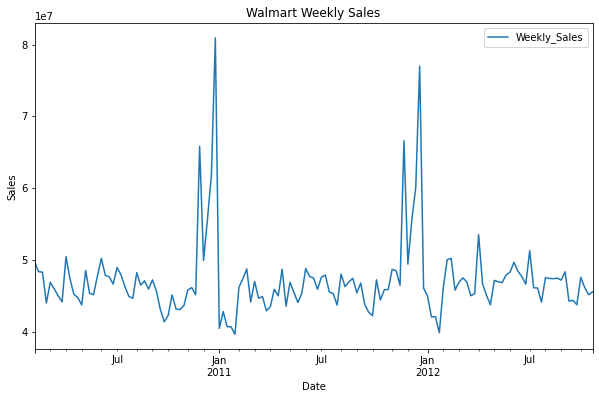

In [7]:
sales.plot(figsize=(10,6), title='Walmart Weekly Sales')
plt.ylabel('Sales');

### ETS

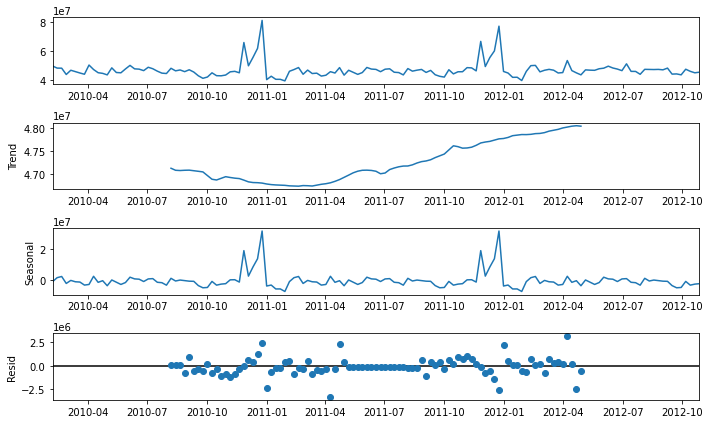

In [8]:
## Seasonal Decompose to visualize Error, Tren & Seasonality

from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

result = seasonal_decompose(sales)
rcParams['figure.figsize'] = 10,6
result.plot();

### Simple Moving Average-SMA 
### & 
### Exponential Weighted Moving AVerage - EWMA

In [9]:
sales['6-month-SWA'] = sales['Weekly_Sales'].rolling(window=6).mean()
sales['12-month-SWA'] = sales['Weekly_Sales'].rolling(window=12).mean()
sales['EWMA-12'] = sales['Weekly_Sales'].ewm(span=12).mean()
sales.dropna(inplace=True)

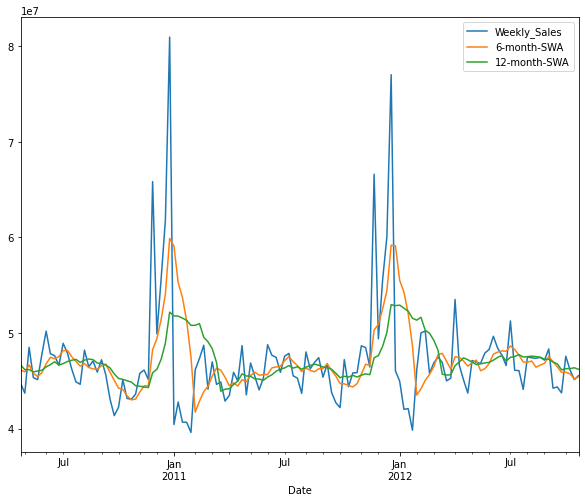

In [10]:
sales[['Weekly_Sales', '6-month-SWA', '12-month-SWA']].plot(figsize=(10,8))

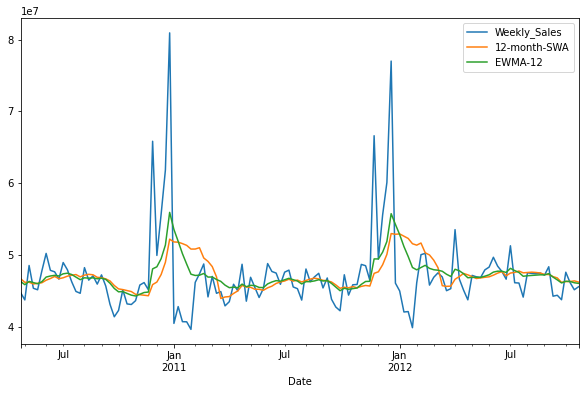

In [11]:
sales[['Weekly_Sales','12-month-SWA','EWMA-12']].plot()

In [12]:
sales.head()

,Weekly_Sales,6-month-SWA,12-month-SWA,EWMA-12
Date,,,,
2010-04-24,44734452.56,4.613836e+07,4.666334e+07,4.627713e+07
2010-05-01,43705126.71,4.592439e+07,4.615953e+07,4.583053e+07
2010-05-08,48503243.52,4.665260e+07,4.617341e+07,4.628561e+07
2010-05-15,45330080.20,4.580364e+07,4.592784e+07,4.612554e+07
2010-05-22,45120108.06,4.542945e+07,4.602380e+07,4.595939e+07


## Holt's Winter Method

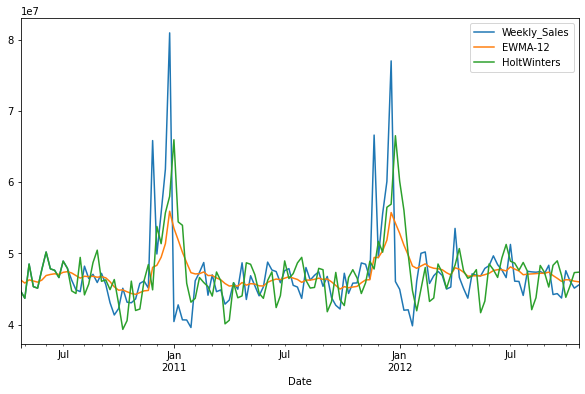

In [13]:
## Triple Exponential Smoothing

from statsmodels.tsa.holtwinters import ExponentialSmoothing

sales['HoltWinters'] = ExponentialSmoothing(sales['Weekly_Sales'],
                                            trend='add',
                                            seasonal='add',
                                            seasonal_periods=12).fit().fittedvalues
sales[['Weekly_Sales', 'EWMA-12', 'HoltWinters']].plot(figsize=(10,6))
plt.show();

## Stationarity

In [14]:
xyz = adf_test(sales['Weekly_Sales'], title='DFT')

Augmented Dickey-Fuller Test: DFT
ADF test statistic       -3.877766
p-value                   0.002205
# lags used              12.000000
# observations          119.000000
critical value (1%)      -3.486535
critical value (5%)      -2.886151
critical value (10%)     -2.579896
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


## ACF & PACF

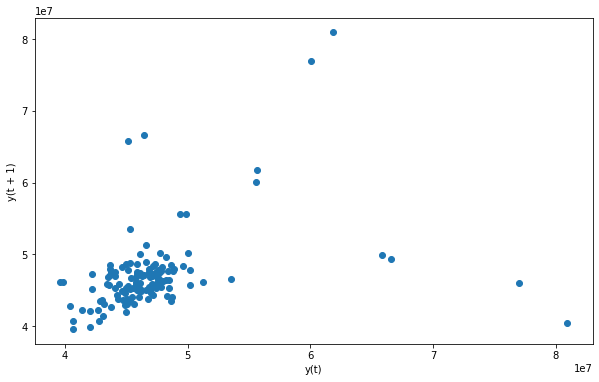

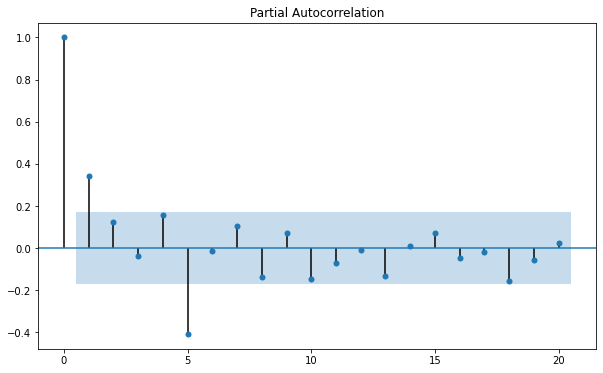

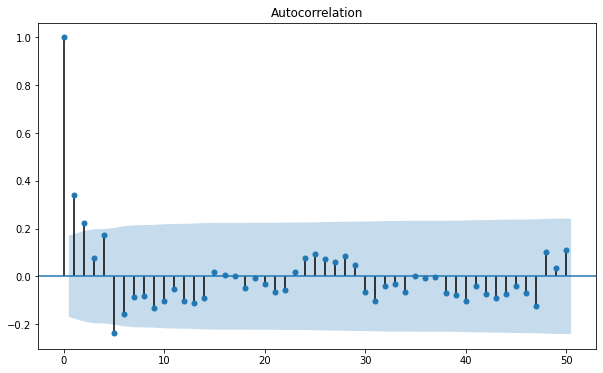

In [15]:
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
lag_plot(sales['Weekly_Sales'])
plot_pacf(sales['Weekly_Sales'],lags=20);
plot_acf(sales['Weekly_Sales'],lags=50);

## Not the best practice to read p,d,q values off the plots as these could be very difficult to read at times. 
## Instead set a grid search method to find the best parameters

ACF: Significant till pth lags

PACF: Geometric

MA process where AR=0, i=1, MA=1

## ARIMA

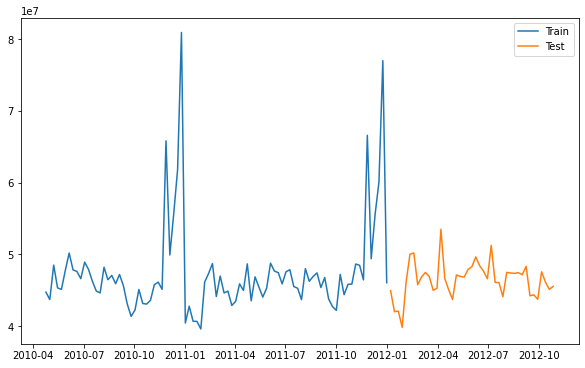

In [16]:
## Need to divide the data into train and validation sets. 

train = sales[['Weekly_Sales']].loc['2010':'2011']
test = sales[['Weekly_Sales']].loc['2012']
plt.plot(train,label='Train')
plt.plot(test, label='Test')
plt.legend()

In [17]:
from pmdarima.arima import auto_arima
arima = auto_arima(train, d=1)

In [18]:
arima

ARIMA(order=(0, 1, 1), scoring_args={}, with_intercept=False)

In [19]:
from statsmodels.tsa.arima_model import ARIMA
p = 14
d = 1
q = 2

arima_mod = ARIMA(train['Weekly_Sales'],order=(p,d,q))
results = arima_mod.fit()

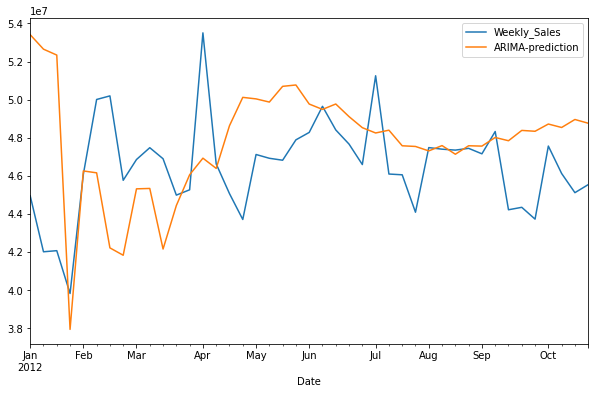

In [20]:
start = len(train)
end = len(train)+len(test)-1

predictions = results.predict(start=start,
                              end=end,
                              typ='levels').rename('ARIMA Predictions')
test['ARIMA-prediction'] = predictions
test.plot(figsize=(10,6))

## SARIMA 

In [21]:
auto_arima(train['Weekly_Sales'],
           seasonal=True,m=14).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   89
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1517.201
Date:                Sat, 17 Oct 2020   AIC                           3042.403
Time:                        11:56:37   BIC                           3052.357
Sample:                             0   HQIC                          3046.415
                                 - 89                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.529e+07   9.86e-10   2.56e+16      0.000    2.53e+07    2.53e+07
ar.L1          0.2630      0.065      4.051      0.000       0.136       0.390
ar.L2          0.2047      0.070      2.910      0.004       0.067       0.343
sigma2      3.814e+13   5.95e-16   6.41e+28      0.000    3.81e+13    3.81e+13
===================================================================================
Ljung-Box (Q):                       24.93   Jarque-Bera (JB):               331.26
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              10.42   Skew:                             2.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.49e+44. Standard errors may be unstable.
"""

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_mod = SARIMAX(sales['Weekly_Sales'],
                order=(4,1,2),
                seasonal_order=(2,0,2,7),
                enforce_invertibility=False)
sarima_mod = sarima_mod.fit()

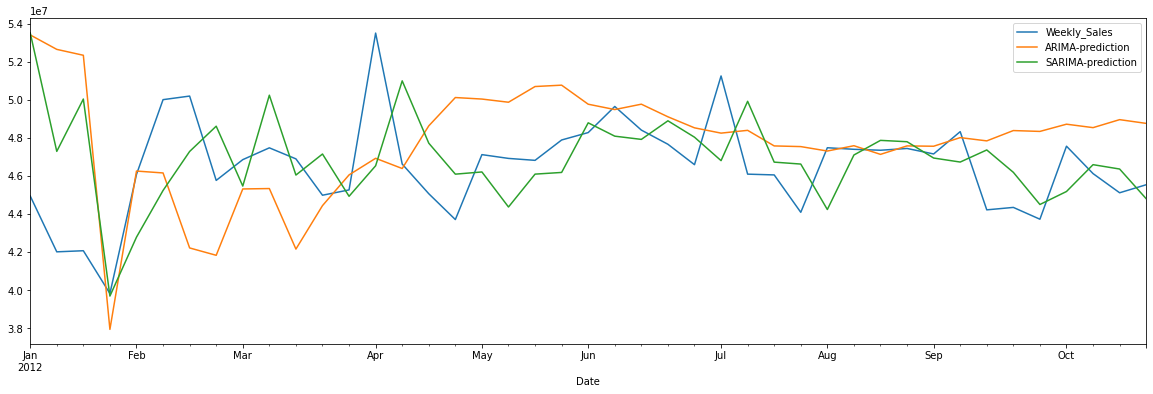

In [23]:
predictions = sarima_mod.predict(start=start,
                              end=end,
                              typ='levels').rename('SARIMA Predictions')
test['SARIMA-prediction'] = predictions

test.plot(figsize=(20,6))

In [24]:
print('ARIMA-MAPE|MdAPE: %.2f|%.2f'%(mean_absolute_percentage_error(test['Weekly_Sales'], 
                                                              test['ARIMA-prediction']), 
                               MdAPE(test['Weekly_Sales'],
                                     test['ARIMA-prediction'])))

print('SARIMA-MAPE|MdAPE: %.2f|%.2f'%(mean_absolute_percentage_error(test['Weekly_Sales'], 
                                                              test['SARIMA-prediction']), 
                               MdAPE(test['Weekly_Sales'],
                                     test['SARIMA-prediction'])))

ARIMA-MAPE|MdAPE: 6.47|5.23
SARIMA-MAPE|MdAPE: 4.96|3.56


## Deep Learning

https://github.com/neelabhpant/Deep-Learning-in-Python/blob/master/ClimateChange_Prediction.ipynb

The above page is another tutorial on Time Series basics and some advance methods. The dataset used in this tutorial is from climate change in the world and if we can use ML to forecast the trend of the future climate change. 

In [25]:
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler()
sc.fit(train)

scaled_train = sc.transform(train)
scaled_test = sc.transform(test[['Weekly_Sales']])

X_train = scaled_train[:-1]
y_train = scaled_train[1:]

X_test = scaled_test[:-1]
y_test = scaled_test[1:]

In [26]:
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.optimizers import Adam
import keras.backend as K

K.clear_session()
np.random.seed(7)
model = Sequential()
model.add(Dense(7, input_dim=1, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error',optimizer=Adam(lr=0.001))
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150)

Using TensorFlow backend.


Train on 88 samples, validate on 42 samples
Epoch 1/150
88/88 [==============================] - 0s 927us/step - loss: 1.1176 - val_loss: 0.2281
Epoch 2/150
88/88 [==============================] - 0s 54us/step - loss: 1.1093 - val_loss: 0.2237
Epoch 3/150
88/88 [==============================] - 0s 60us/step - loss: 1.1026 - val_loss: 0.2194
Epoch 4/150
88/88 [==============================] - 0s 51us/step - loss: 1.0948 - val_loss: 0.2152
Epoch 5/150
88/88 [==============================] - 0s 58us/step - loss: 1.0882 - val_loss: 0.2112
Epoch 6/150
88/88 [==============================] - 0s 56us/step - loss: 1.0813 - val_loss: 0.2077
Epoch 7/150
88/88 [==============================] - 0s 44us/step - loss: 1.0746 - val_loss: 0.2042
Epoch 8/150
88/88 [==============================] - 0s 57us/step - loss: 1.0683 - val_loss: 0.2009
Epoch 9/150
88/88 [==============================] - 0s 53us/step - loss: 1.0635 - val_loss: 0.1977
Epoch 10/150
88/88 [==============================] - 0

Epoch 82/150
88/88 [==============================] - 0s 48us/step - loss: 0.9179 - val_loss: 0.1675
Epoch 83/150
88/88 [==============================] - 0s 43us/step - loss: 0.9178 - val_loss: 0.1677
Epoch 84/150
88/88 [==============================] - 0s 45us/step - loss: 0.9167 - val_loss: 0.1677
Epoch 85/150
88/88 [==============================] - 0s 47us/step - loss: 0.9164 - val_loss: 0.1677
Epoch 86/150
88/88 [==============================] - 0s 52us/step - loss: 0.9160 - val_loss: 0.1679
Epoch 87/150
88/88 [==============================] - 0s 49us/step - loss: 0.9157 - val_loss: 0.1680
Epoch 88/150
88/88 [==============================] - 0s 50us/step - loss: 0.9153 - val_loss: 0.1682
Epoch 89/150
88/88 [==============================] - 0s 46us/step - loss: 0.9153 - val_loss: 0.1684
Epoch 90/150
88/88 [==============================] - 0s 41us/step - loss: 0.9144 - val_loss: 0.1684
Epoch 91/150
88/88 [==============================] - 0s 48us/step - loss: 0.9143 - val_los

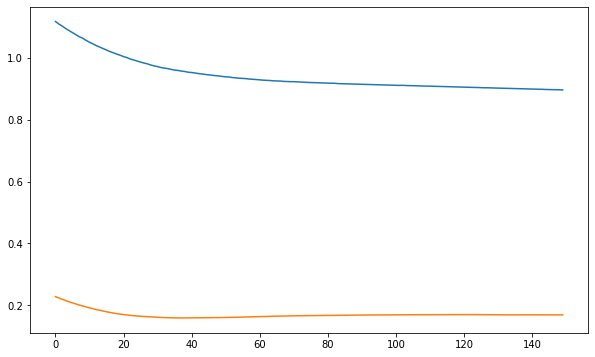

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

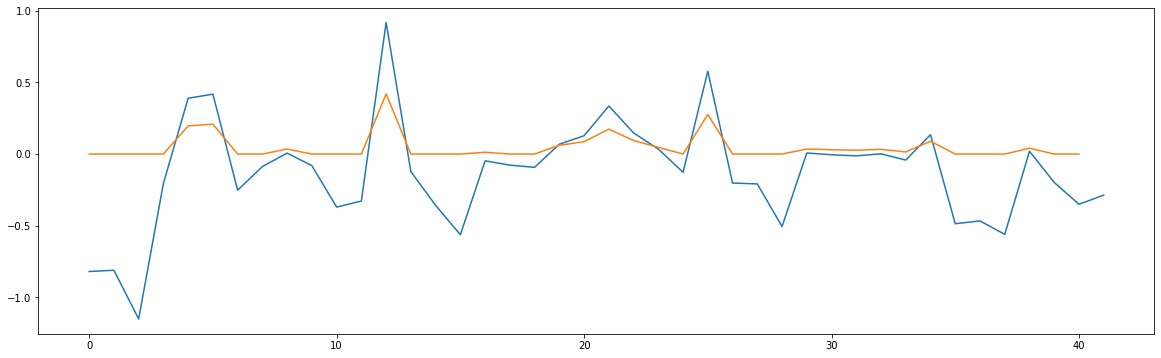

In [28]:
X_test_NN = np.insert(X_test,0,X_train[-1][0])
predictions = model.predict(X_test_NN)
predictions = pd.DataFrame(predictions, columns=['FNN'])
plt.figure(figsize=(20,6))
plt.plot(y_test)
plt.plot(predictions.shift(-2))

In [29]:
print('ARIMA-MAPE|MdAPE: %.2f|%.2f'%(mean_absolute_percentage_error(test['Weekly_Sales'], 
                                                              test['ARIMA-prediction']), 
                               MdAPE(test['Weekly_Sales'],
                                     test['ARIMA-prediction'])))

print('SARIMA-MAPE|MdAPE: %.2f|%.2f'%(mean_absolute_percentage_error(test['Weekly_Sales'], 
                                                              test['SARIMA-prediction']), 
                               MdAPE(test['Weekly_Sales'],
                                     test['SARIMA-prediction'])))

print('FNN-MAPE|MdAPE: %.2f|%.2f'%(mean_absolute_percentage_error(sc.inverse_transform(y_test[:-1]),sc.inverse_transform(predictions[['FNN']].shift(-2)[:-2])), 
                                   MdAPE(sc.inverse_transform(y_test[:-1]),sc.inverse_transform(predictions[['FNN']].shift(-2)[:-2]))))

ARIMA-MAPE|MdAPE: 6.47|5.23
SARIMA-MAPE|MdAPE: 4.96|3.56
FNN-MAPE|MdAPE: 3.69|2.55


## LSTM

#### Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems.

#### Read more about LSTM and Deep Neural Networks at:

https://blog.statsbot.co/time-series-prediction-using-recurrent-neural-networks-lstms-807fa6ca7f

https://towardsdatascience.com/a-gentle-introduction-to-neural-networks-series-part-1-2b90b87795bc

##### LSTM needs to define (Batch Size x Nbr of Batches x Features)
##### 3-D tensor


In [30]:
X_train_t = X_train[:,None]
X_test_t = X_test[:,None]

Train on 88 samples, validate on 42 samples
Epoch 1/100
88/88 [==============================] - 0s 4ms/step - loss: 0.9465 - val_loss: 0.1444
Epoch 2/100
88/88 [==============================] - 0s 101us/step - loss: 0.9435 - val_loss: 0.1438
Epoch 3/100
88/88 [==============================] - 0s 92us/step - loss: 0.9412 - val_loss: 0.1432
Epoch 4/100
88/88 [==============================] - 0s 90us/step - loss: 0.9395 - val_loss: 0.1427
Epoch 5/100
88/88 [==============================] - 0s 94us/step - loss: 0.9360 - val_loss: 0.1421
Epoch 6/100
88/88 [==============================] - 0s 70us/step - loss: 0.9349 - val_loss: 0.1418
Epoch 7/100
88/88 [==============================] - 0s 70us/step - loss: 0.9322 - val_loss: 0.1413
Epoch 8/100
88/88 [==============================] - 0s 68us/step - loss: 0.9304 - val_loss: 0.1410
Epoch 9/100
88/88 [==============================] - 0s 65us/step - loss: 0.9278 - val_loss: 0.1405
Epoch 10/100
88/88 [==============================] - 0s

Epoch 82/100
88/88 [==============================] - 0s 56us/step - loss: 0.7762 - val_loss: 0.1399
Epoch 83/100
88/88 [==============================] - 0s 60us/step - loss: 0.7758 - val_loss: 0.1407
Epoch 84/100
88/88 [==============================] - 0s 59us/step - loss: 0.7729 - val_loss: 0.1413
Epoch 85/100
88/88 [==============================] - 0s 56us/step - loss: 0.7712 - val_loss: 0.1420
Epoch 86/100
88/88 [==============================] - 0s 57us/step - loss: 0.7696 - val_loss: 0.1426
Epoch 87/100
88/88 [==============================] - 0s 55us/step - loss: 0.7682 - val_loss: 0.1431
Epoch 88/100
88/88 [==============================] - 0s 56us/step - loss: 0.7669 - val_loss: 0.1441
Epoch 89/100
88/88 [==============================] - 0s 59us/step - loss: 0.7655 - val_loss: 0.1448
Epoch 90/100
88/88 [==============================] - 0s 61us/step - loss: 0.7648 - val_loss: 0.1455
Epoch 91/100
88/88 [==============================] - 0s 56us/step - loss: 0.7623 - val_los

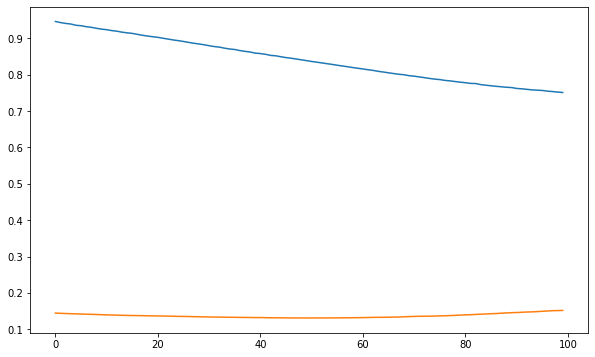

In [31]:
np.random.seed(7)

K.clear_session()
model = Sequential()

model.add(LSTM(20, input_shape=(1,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
model.fit(X_train_t, y_train, validation_data=(X_test_t, y_test), epochs=100, verbose=1)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])

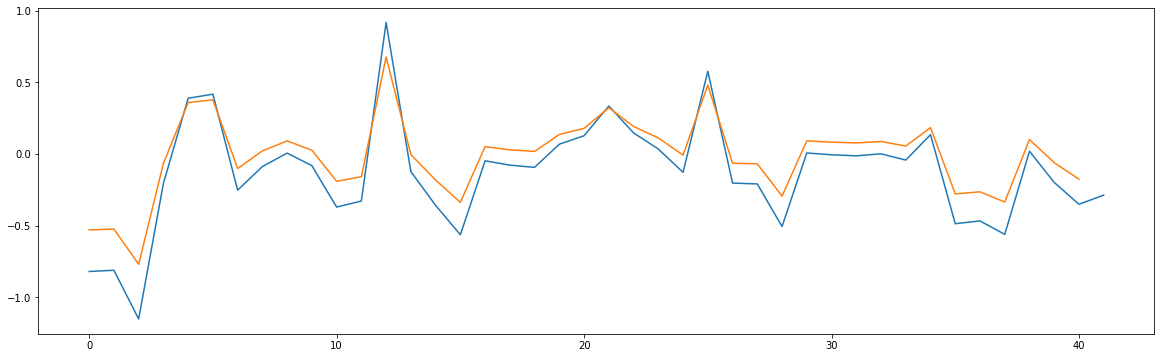

In [32]:
X_test_LSTM = np.insert(X_test,0,X_train[-1][0]).reshape(-1,1)
X_test_LSTM = X_test_LSTM[:,None]
X_test_LSTM.shape
predictions_LSTM = model.predict(X_test_LSTM)
predictions['LSTM'] = predictions_LSTM
plt.figure(figsize=(20,6))
plt.plot(y_test)
plt.plot(predictions[['LSTM']].shift(-2))

In [33]:
print('ARIMA-MAPE|MdAPE: %.2f|%.2f'%(mean_absolute_percentage_error(test['Weekly_Sales'], 
                                                              test['ARIMA-prediction']), 
                               MdAPE(test['Weekly_Sales'],
                                     test['ARIMA-prediction'])))

print('SARIMA-MAPE|MdAPE: %.2f|%.2f'%(mean_absolute_percentage_error(test['Weekly_Sales'], 
                                                              test['SARIMA-prediction']), 
                               MdAPE(test['Weekly_Sales'],
                                     test['SARIMA-prediction'])))

print('FNN-MAPE|MdAPE: %.2f|%.2f'%(mean_absolute_percentage_error(sc.inverse_transform(y_test[:-1]),sc.inverse_transform(predictions[['FNN']].shift(-2)[:-2])), 
                                   MdAPE(sc.inverse_transform(y_test[:-1]),sc.inverse_transform(predictions[['FNN']].shift(-2)[:-2]))))

print('LSTM-MAPE|MdAPE: %.2f|%.2f'%(mean_absolute_percentage_error(sc.inverse_transform(y_test[:-1]),sc.inverse_transform(predictions[['LSTM']].shift(-2)[:-2])), 
                                   MdAPE(sc.inverse_transform(y_test[:-1]),sc.inverse_transform(predictions[['LSTM']].shift(-2)[:-2]))))

ARIMA-MAPE|MdAPE: 6.47|5.23
SARIMA-MAPE|MdAPE: 4.96|3.56
FNN-MAPE|MdAPE: 3.69|2.55
LSTM-MAPE|MdAPE: 1.97|1.57


#### BIG PROBLEM WITH FORECASTING NEURAL NETWORKS WE BUILT ABOVE:
##### Figure out what the problem is
##### Start a discussion and try to solve the problem
###### Hint: Time series forecast shoud never be based on ground truth.

## Prophet

In [34]:
from fbprophet import Prophet
train.reset_index(inplace=True)

In [35]:
train.head()

,Date,Weekly_Sales
0,2010-04-24,44734452.56
1,2010-05-01,43705126.71
2,2010-05-08,48503243.52
3,2010-05-15,45330080.20
4,2010-05-22,45120108.06


In [36]:
train.columns = ['ds', 'y']
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      89 non-null     datetime64[ns]
 1   y       89 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.5 KB


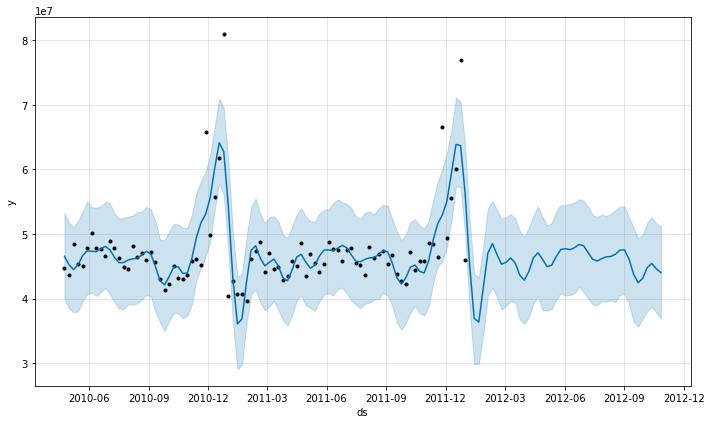

In [37]:
from holidayevents import calendar_holidays

m = Prophet(yearly_seasonality=True,
            daily_seasonality=True,weekly_seasonality=True,
            holidays=calendar_holidays(),
            interval_width=0.9)
m.fit(train)

future = m.make_future_dataframe(periods=test.shape[0],freq='W-SAT',include_history=True)
forecast_entire = m.predict(future)
m.plot(forecast_entire);

forecast = forecast_entire[['ds','yhat']]
forecast.set_index(keys=['ds'], inplace=True)

In [38]:
test['Prophet'] = forecast.loc['2012-01':]

In [39]:
print('ARIMA-MAPE|MdAPE: %.2f|%.2f'%(mean_absolute_percentage_error(test['Weekly_Sales'], 
                                                              test['ARIMA-prediction']), 
                               MdAPE(test['Weekly_Sales'],
                                     test['ARIMA-prediction'])))

print('SARIMA-MAPE|MdAPE: %.2f|%.2f'%(mean_absolute_percentage_error(test['Weekly_Sales'], 
                                                              test['SARIMA-prediction']), 
                               MdAPE(test['Weekly_Sales'],
                                     test['SARIMA-prediction'])))

print('FNN-MAPE|MdAPE: %.2f|%.2f'%(mean_absolute_percentage_error(sc.inverse_transform(y_test[:-1]),sc.inverse_transform(predictions[['FNN']].shift(-2)[:-2])), 
                                   MdAPE(sc.inverse_transform(y_test[:-1]),sc.inverse_transform(predictions[['FNN']].shift(-2)[:-2]))))

print('LSTM-MAPE|MdAPE: %.2f|%.2f'%(mean_absolute_percentage_error(sc.inverse_transform(y_test[:-1]),sc.inverse_transform(predictions[['LSTM']].shift(-2)[:-2])), 
                                   MdAPE(sc.inverse_transform(y_test[:-1]),sc.inverse_transform(predictions[['LSTM']].shift(-2)[:-2]))))


print('Prophet-MAPE|MdAPE: %.2f|%.2f'%(mean_absolute_percentage_error(test['Weekly_Sales'], 
                                                              test['Prophet']), 
                               MdAPE(test['Weekly_Sales'],
                                     test['Prophet'])))

ARIMA-MAPE|MdAPE: 6.47|5.23
SARIMA-MAPE|MdAPE: 4.96|3.56
FNN-MAPE|MdAPE: 3.69|2.55
LSTM-MAPE|MdAPE: 1.97|1.57
Prophet-MAPE|MdAPE: 3.52|2.66


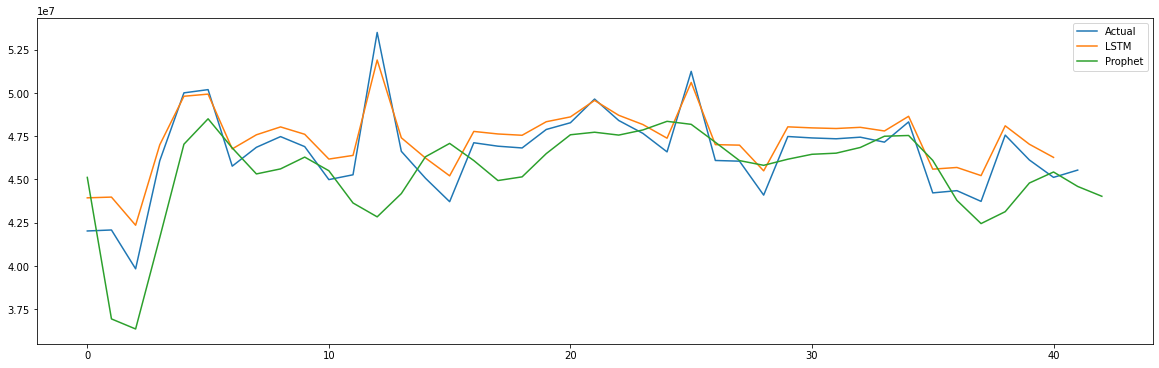

In [40]:
plt.figure(figsize=(20,6))
plt.plot(sc.inverse_transform(y_test), label='Actual')
plt.plot(sc.inverse_transform(predictions[['LSTM']].shift(-2)), label='LSTM')
plt.plot(test['Prophet'].values, label='Prophet')
plt.legend()